In [62]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, probplot

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [63]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
test_df = pd.read_csv('data/test.csv', index_col='Id')

In [64]:
print(train_df.shape)
test_df.shape

(1460, 80)


(1459, 79)

In [4]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
catCols = list(train_df.select_dtypes(include='object').columns)
print(f'Number of categorical variables: {len(catCols)}')
print(catCols)

Number of categorical variables: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [6]:
numCols = list(train_df.select_dtypes(include='number').columns)
print(f'Number of numerical variables: {len(numCols)}')
print(numCols)

Number of numerical variables: 37
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


MSSubClass(nominal), OverallQual(ordinal), OverallCond(ordinal), 

<b> Plot Phân phối SalePrice </b>

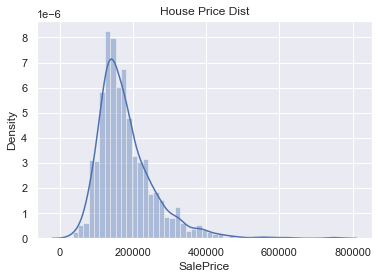

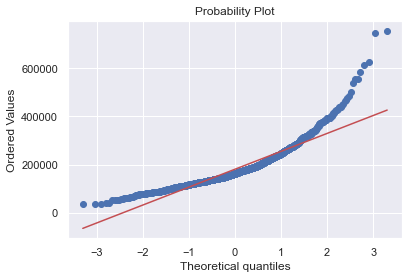

In [65]:
sns.distplot(train_df.SalePrice)
plt.title('House Price Dist');
fig = plt.figure()
res = probplot(train_df.SalePrice, plot=plt);

Nhận xét: SalePrice có dạng hơi lệch khỏi phân phối chuẩn một chút về bên phải

#### Outliers

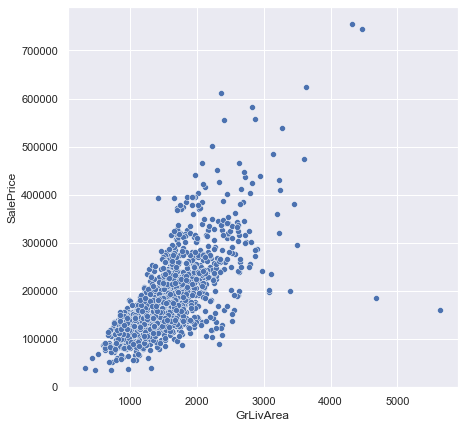

In [66]:
# Xem mối quan hệ giữa GrLivArea và SalePrice
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

<b>Nhận xét: 2 điểm ở góc phải bên dưới khá khác biệt so với các điểm còn lại, đi ngược lại xu hướng, nên khả năng rất cao đây là 2 điểm ngoại lai </b> <br>
<b> --> Nên ta sẽ loại bỏ chúng </b>

In [67]:
outlier_index = train_df[(train_df.GrLivArea > 4000) & (train_df.SalePrice < 200000)].index
train_df.drop(outlier_index,axis=0, inplace=True)

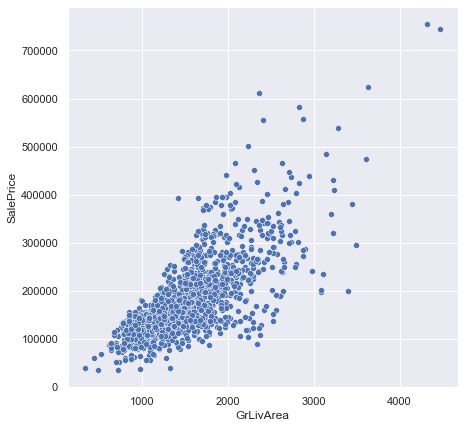

In [68]:
# Xem mối quan hệ giữa GrLivArea và SalePrice sau khi đã bỏ outliers
fg = plt.figure(figsize=(7,7))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice']);

#### <b>Ma trận tương quan</b>

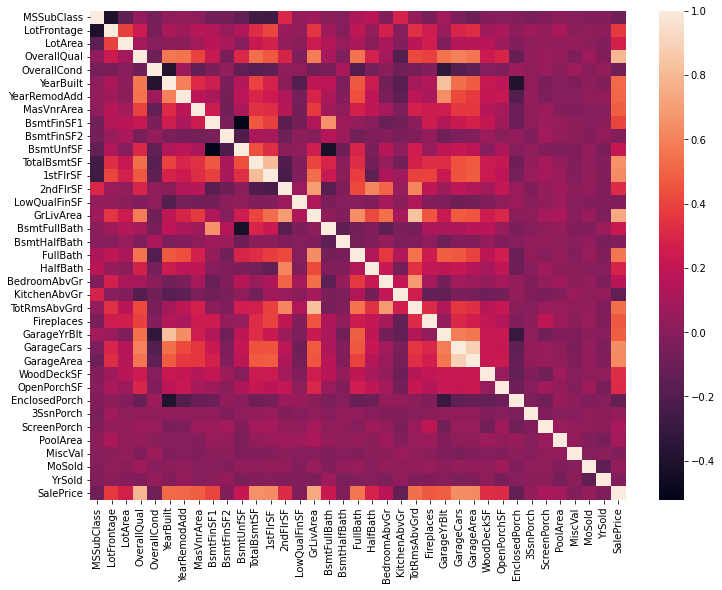

In [11]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr);

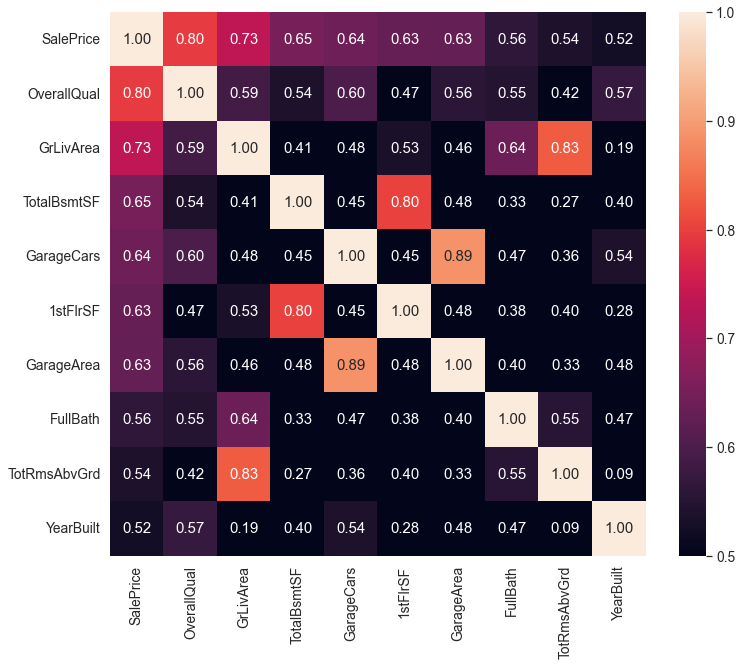

In [12]:
# 10 đặc trưng có độ tương quan lớn nhất với SalePrice
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(12,10))
# Select correlations greater than 0.5
hm = sns.heatmap(cm, annot=True,fmt='.2f', yticklabels=cols.values, xticklabels=cols.values, vmin = 0.5, vmax=1.)
plt.show();

<b>Nhận xét</b>: Ở đây xảy ra hiện tượng Muiticollinearity
* OverallQual, GrLivArea, TotalBsmtSF tương quan nhiều với SalePrice.
* GarageCars và GarageArea khá tương đồng nhau vì diện tích Garage càng lớn thì càng để được nhiều Oto, và ngược lại, nên có thể bỏ 1 cái, giữ lại GarageCars vì có độ tương đồng với SalePrice lớn hơn.
* TotalBsmtSF và 1stFlrSF cũng khá tương đồng nhau, giữ lại TotalBsmtSF
* FullBath: Không đóng vai trò lớn trong việc quyết định giá nhà.
* TotRmsAbvGrd và GrLivArea: giá tương đồng nhau --> bỏ TotRmsAbvGrd
* Giữ lại YearBuilt: vì quan trọng trong việc quyết định giá nhà.<br>

<b>Nhưng nếu chỉ cần dùng model để dự đoán giá nhà thì không nhất thiết phải bỏ đi các features tương quan nhau </b>

### PLot những đặc trưng có độ tương quan cao với SalePrice

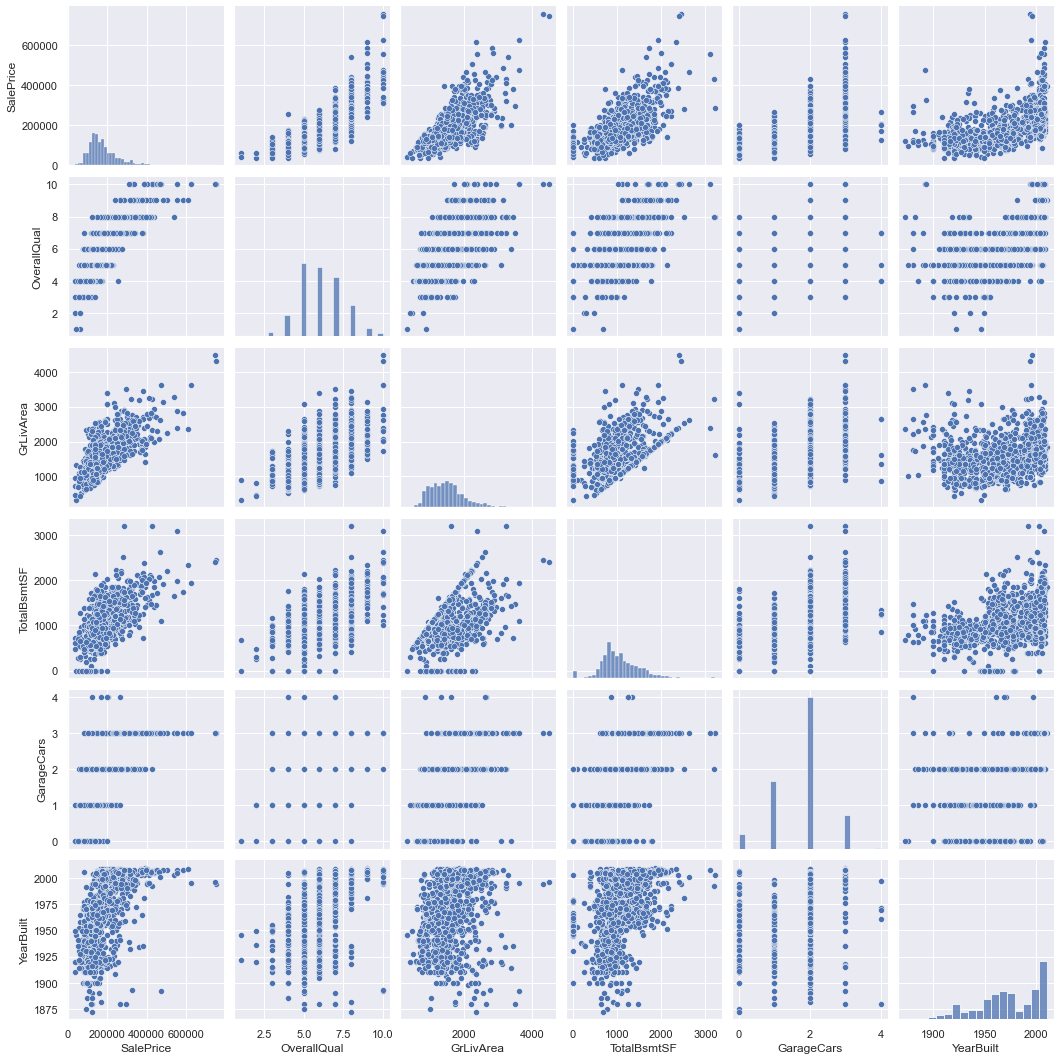

In [13]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']
sns.pairplot(train_df[cols])
plt.show();

<b>Kết hợp train và test data</b>

In [69]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y = train_df.SalePrice
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f'Shape all data:{all_data.shape}')


Shape all data:(2917, 79)


<b>Missing data</b>

In [70]:
missing_data_count = all_data.isna().sum()
missing_data_percent = missing_data_count / len(all_data) * 100
missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)
print('There are {} features that have missing values'.format(len(missing_data.index)))
missing_data.head(34)

There are 34 features that have missing values


,Count,Percent
PoolQC,2908,99.691
MiscFeature,2812,96.400
Alley,2719,93.212
Fence,2346,80.425
FireplaceQu,1420,48.680
LotFrontage,486,16.661
GarageFinish,159,5.451
GarageQual,159,5.451
GarageCond,159,5.451
GarageYrBlt,159,5.451


##### <b>Xử lý dữ liệu bị thiếu (missing values) </b> <br>
Dựa vào file mô tả data:

In [71]:
# PoolQC : NA là "No Pool".
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [72]:
# MiscFeature : NA là "no misc feature"
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [73]:
# Alley : NA là "no alley access"
all_data['Alley'] = all_data['Alley'].fillna('None')

In [74]:
# Fence : NA là "no fence"
all_data['Fence'] = all_data['Fence'].fillna('None')

In [75]:
# FireplaceQu : NA -> No FireplaceQu 
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [76]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [77]:
# GarageType, GarageFinish, GarageQual and GarageCond: thay thế NA bằng None
for col in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    all_data[col] = all_data[col].fillna('None')

In [78]:
# GarageYrBlt, GarageArea and GarageCars: thay thế NA bằng 0
for col in ["GarageYrBlt", "GarageArea", "GarageCars"]:
    all_data[col] = all_data[col].fillna(0)

In [79]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : thay thế NA bằng 0
for col in ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]:
    all_data[col] = all_data[col].fillna(0)

In [80]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2: thay thế NA bằng None
for col in ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1" , "BsmtFinType2"]:
    all_data[col] = all_data[col].fillna('None')

In [81]:
# MasVnrArea and MasVnrType
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

In [82]:
most_common_MSZoning = all_data['MSZoning'].value_counts().index[0]
all_data['MSZoning'] = all_data['MSZoning'].fillna(most_common_MSZoning)

In [83]:
# Đặc trưng Utilies ở tập train không bị thiếu data, và chỉ có 1 sample có giá trị là NoSewa, còn lại toàn là AllPub
# Vậy nên nó không có góp phần tăng khả năng dự đoán của model --> ta có thể bỏ nó đi.
all_data.drop(['Utilities'], axis=1, inplace=True)

In [84]:
# Functional: File mô tả nói Functional sẽ bằng Typical nếu không có cảnh báo Deductions
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [85]:
# Electrical: có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_Electrical = all_data['Electrical'].value_counts().index[0]
all_data['Electrical'] = all_data['Electrical'].fillna(most_common_Electrical)

In [86]:
# KitchenQual: có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_KitchenQual = all_data['KitchenQual'].value_counts().index[0]
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(most_common_KitchenQual)

In [87]:
# Exterior1st and Exterior2nd: đều có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_Exterior1st = all_data['Exterior1st'].value_counts().index[0]
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(most_common_Exterior1st)

most_common_Exterior2nd = all_data['Exterior2nd'].value_counts().index[0]
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(most_common_Exterior2nd)

In [88]:
# SaleType : có 1 missing value, thay bằng giá trị phổ biến nhất
most_common_SaleType = all_data['SaleType'].value_counts().index[0]
all_data['SaleType'] = all_data['SaleType'].fillna(most_common_SaleType)

<b> Check xem còn missing values không</b>

In [95]:
all_data.isna().sum().sum()

0

<b>Một số features ở dạng Numerical nhưng thực chất các giá trị của chúng chỉ ở trong một tập giá trị nhất định -> chúng là các biến dạng Categorical</b> <br>
-> Chuyển chúng sang dạng Categorical

In [90]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

<b>Label Encoding một số biến Categorical</b>

In [91]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
        
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


<b>Skewed Features </b> <br>
Đưa 1 số features numeric bị lệch phải về dạng phân phối normal dist

In [93]:
numeric_feats = all_data.select_dtypes(include='number').columns
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x))
skewed_feats = skewed_feats.sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed':skewed_feats})
skewness.head(10)

,Skewed
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [94]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 58 skewed numerical features to Box Cox transform


<b>Tạo dummy cho các biến Categorical </b>

In [128]:
all_data = pd.get_dummies(all_data,
                        drop_first=False)

<b>Normalize dataset </b> <br>
Phạm vi giá trị của các features không giống nhau, nên cần đưa về cùng một phạm vi <br>
Ở đây ta đưa về phân phối chuẩn có mean = 0, std = 1

In [129]:
all_data_scaled = all_data.apply(lambda x : (x - x.mean())/x.std())

<b>Chia tập train và test data </b>

In [131]:
train = all_data_scaled[:ntrain]
test = all_data_scaled[ntrain:]

<b>Model</b>

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42)

In [133]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9066493262128901

In [139]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9172124839271267

In [135]:
pred = pd.DataFrame(model.predict(test))
sub_df=pd.read_csv('data/sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']

# datasets.drop([1459],inplace=True)
datasets.isnull()
datasets.to_csv('data/sample_submission.csv',index=False)

datasets.head()

,Id,SalePrice
0,1461,122350.811
1,1462,154233.145
2,1463,181929.252
3,1464,185479.184
4,1465,202840.914
